In [1]:
import pandas as pd 
import numpy as np 
import nltk 
import glob

data = []
all_files = glob.glob(r'data' + "/*.csv")

for filename in all_files:
    d = pd.read_csv(filename)
    data.append(d)

df = pd.concat(data, sort=True)

df.sample(5)

,Unnamed: 0,comment,flair
5195,5195,\> the wild west \n\ncome on ...,:libright: - LibRight
9615,9615,Oversimplified reference in AuthLeft?,:authleft: - AuthLeft
5159,5159,"Well hold on, Somalias been around for quite a...",:left: - Left
10892,10892,with my PoliticalCompassMeme-inator!,:left: - Left
12072,12072,Should auld acquaintance be forgot and never b...,:centrist: - Centrist


In [2]:
%load_ext tensorboard

## Data Preprocessing

In [3]:
for c in df.columns:
    na_count = df[c].isna().sum()
    if na_count > 0:
        print(f'{c} has {na_count} nulls')
    else:
        print(f'{c} has no nulls')

Unnamed: 0 has no nulls
comment has no nulls
flair has no nulls


In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
#cleaing flair values
df['flair'] = df['flair'].astype(str)
def get_last(text):
    tlist = text.split()
    return tlist[-1]

df['flair'] = df.apply(lambda x: get_last(x['flair']), axis=1)

In [6]:
df['flair'].unique()

array(['Right', 'LibRight', 'LibLeft', 'Centrist', 'AuthCenter',
       'LibCenter', 'AuthLeft', 'AuthRight', 'Left'], dtype=object)

In [7]:
df['flair'].value_counts()

LibRight      13948
Centrist      10709
LibLeft        7957
LibCenter      7694
Right          6205
AuthRight      5236
AuthCenter     5037
Left           3388
AuthLeft       3124
Name: flair, dtype: int64

### Text Preprocessing

In [8]:
#remove stopwords, punctuations and expand contractions
import string
from nltk.corpus import stopwords
import contractions
import re

#stop = stopwords.words('english')
punc = string.punctuation
 
def clean_text(text):
    #expand contractions
    text_contract_fixed = contractions.fix(text)
    #stop_removed = ' '.join([t for t in text_contract_fixed.lower().split() if t not in stop])
    #remove punctiations
    punc_removed = ' '.join(s for s in text_contract_fixed.split() if s not in punc)
    #num_removed = re.sub(r'\d+', '', punc_removed)
    #no_doublespace = re.sub('\s+', ' ', punc_removed).strip()
    return punc_removed

df['comment'] = df.apply(lambda x: clean_text(x['comment']), axis=1)

### Evaluating Word Counts
Every input in the model will need to have the same length. Shorter inputs can be padded with 0's and longer inputs can be trimmed. There needs to be a set word length to minimize padding and trimming.

In [9]:
#create word count column
df['word_count'] = df['comment'].apply(lambda x: len(str(x).split(" ")))

print('Max:', df['word_count'].max())
print('Min:', df['word_count'].min())
print('Mean:', df['word_count'].mean())
print('Standard Deviation:', df['word_count'].std())
print('Nulls:', df['comment'].isna().sum())

Max: 2500
Min: 1
Mean: 15.990205061771304
Standard Deviation: 34.16996008147011
Nulls: 0


In [10]:
#drop rows with 2 or less words
df = df[df['word_count']>2]

print('Max:', df['word_count'].max())
print('Min:', df['word_count'].min())
print('Mean:', df['word_count'].mean())
print('Standard Deviation:', df['word_count'].std())
print('Nulls:', df['comment'].isna().sum())

Max: 2500
Min: 3
Mean: 17.625480997311687
Standard Deviation: 35.665680519638244
Nulls: 0


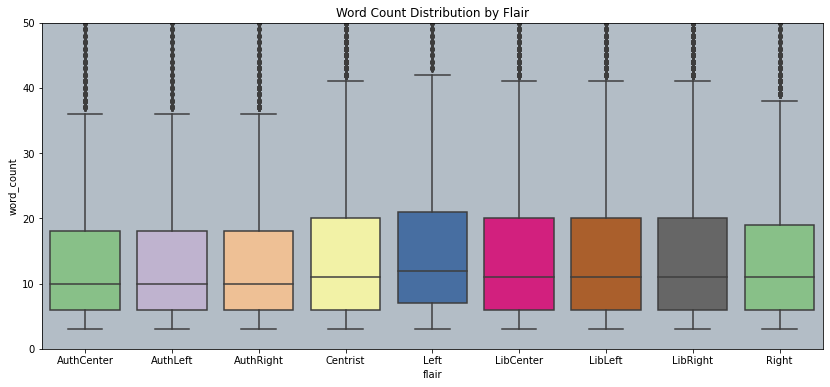

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns 
def plot_box(data, x, y):
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize = (14,6))
    ax = sns.boxplot(data=data.sort_values(x), x= x, y= y, palette= 'Accent')
    ax.set_title('Word Count Distribution by Flair')
    ax.set_facecolor('#b3bdc6')
    ax.set(ylim=(0, 50))

plot_box(df, 'flair', 'word_count')

The input length will be 42, as most comments with more words are outliers in length.

## Create Word Tokens

In [12]:
#tokenizing words

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Maximum number of words to keep based on frequency
MAX_WORDS = 50000
#Max number of words in each comment. 
MAX_LENGTH = 42

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, oov_token='oov')
tokenizer.fit_on_texts(df['comment'].values)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))

#Rule of thumb: embedding vector dimension should be the 4th root of the number of categories
EMBEDDING_DIM = round(float(len(word_index)**0.25))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

X = tokenizer.texts_to_sequences(df['comment'].values)
X = pad_sequences(X, maxlen=MAX_LENGTH, truncating='post', padding='post')
print('Shape of data tensor:', X.shape)

Found 41979 unique tokens.
Shape of data tensor: (56913, 42)


In [13]:
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

## Train-Test Split and Over Sampling

In [14]:
from sklearn.model_selection import train_test_split

y = df['flair']

X_train, X_test, y_train, y_test = train_test_split(  
                    X, y, test_size=0.25, random_state=4)

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=3, k_neighbors=5)
X_train,y_train = smote.fit_resample(X_train,y_train)

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(85194, 42) (85194, 9)
(14229, 42) (14229, 9)


## Model Creation and Hyperparameter Tuning

In [16]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

HP_UNITS = hp.HParam('units', hp.Discrete([64, 96, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.15, 0.2))

METRIC_ACCURACY = 'accuracy'
NUM_CLASSES = y_train.shape[1]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [17]:
def model_build(hparams):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hparams[HP_UNITS])))
    model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
    model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    epochs = 4
    batch_size = 50

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks= [stop_early])
    _, accuracy = model.evaluate(X_test, y_test)
    
    return accuracy

In [18]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = model_build(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [19]:
session_num = 0

for num_units in HP_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        hparams = {
            HP_UNITS: num_units,
            HP_DROPOUT: dropout_rate
            }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1


--- Starting trial: run-0
{'units': 64, 'dropout': 0.15}
Epoch 1/4
1364/1364 [==============================] - 44s 30ms/step - loss: 4.0740 - accuracy: 0.1744 - val_loss: 3.6325 - val_accuracy: 0.0023
Epoch 2/4
1364/1364 [==============================] - 40s 29ms/step - loss: 3.9897 - accuracy: 0.2052 - val_loss: 3.7819 - val_accuracy: 0.0000e+00
Epoch 3/4
1364/1364 [==============================] - 40s 29ms/step - loss: 3.9661 - accuracy: 0.2226 - val_loss: 3.9072 - val_accuracy: 0.0036
Epoch 4/4
445/445 [==============================] - 2s 5ms/step - loss: 2.2857 - accuracy: 0.1833
--- Starting trial: run-1
{'units': 64, 'dropout': 0.2}
Epoch 1/4
1364/1364 [==============================] - 44s 30ms/step - loss: 4.7305 - accuracy: 0.1741 - val_loss: 3.3960 - val_accuracy: 0.0000e+00
Epoch 2/4
1364/1364 [==============================] - 40s 30ms/step - loss: 4.6645 - accuracy: 0.2035 - val_loss: 3.9951 - val_accuracy: 0.0000e+00
Epoch 3/4
1364/1364 [==============================

In [20]:
model_final = tf.keras.Sequential()
model_final.add(tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
model_final.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=96)))
model_final.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
model_final.add(tf.keras.layers.Dropout(0.2))
model_final.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
epochs = 4
batch_size = 50

history = model_final.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks= [stop_early]) 

Epoch 1/4
1364/1364 [==============================] - 70s 49ms/step - loss: 4.7292 - accuracy: 0.1750 - val_loss: 3.6313 - val_accuracy: 0.0000e+00
Epoch 2/4
1364/1364 [==============================] - 65s 48ms/step - loss: 4.7010 - accuracy: 0.2046 - val_loss: 3.9430 - val_accuracy: 1.1738e-04
Epoch 3/4
1364/1364 [==============================] - 68s 50ms/step - loss: 4.6055 - accuracy: 0.2270 - val_loss: 4.0648 - val_accuracy: 0.0055
Epoch 4/4
1364/1364 [==============================] - 75s 55ms/step - loss: 4.5831 - accuracy: 0.2550 - val_loss: 4.3148 - val_accuracy: 0.0117


In [23]:
test_loss, test_acc = model_final.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

445/445 [==============================] - 5s 10ms/step - loss: 2.3382 - accuracy: 0.1686
Test Loss: 2.338200092315674
Test Accuracy: 0.16859933733940125


In [26]:
model_final.save("C:/Users/austi/reddit_text/saved_model", save_format="h5")